In [2]:
import os
import cv2
import sys
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from annotation_utils import *
import warnings
import pandas as pd
import statsmodels.formula.api as smf
import scipy as sp
from scipy import integrate
import math

def action_with_warnings():
    warnings.warn("should not appear")


def get_parallel_curve(points, offset=1.0):
    x, y = points[:,0], points[:,1]
    tck = sp.interpolate.splrep(x, y)
    y_deriv = sp.interpolate.splev(x, tck, der=1)
    normals_rad = np.arctan(y_deriv) + np.pi/2.
    result = points.copy()
    result[:,0] += np.cos(normals_rad) * offset
    result[:,1] += np.sin(normals_rad) * offset
    return result

In [3]:
def fit_parabolic_spline(im, treshold_u):
    with warnings.catch_warnings(record=True):
#             action_with_warnings()
        # algorithms starts here
       

        Z= np.argwhere(im>treshold_u)
        y = Z[:,0].reshape(-1, 1)
        x = Z[:,1].reshape(-1, 1)
        x=x.reshape(-1)
        y=y.reshape(-1)

        quantiles = [  .05]
        df = pd.DataFrame({'predictor': x, 'response': y})

        qregmod = smf.quantreg(formula='response ~  predictor + I(predictor ** 2.0)', data=df)
        # get all result instances in a list
        res_all = [qregmod.fit(q=q, max_iter=1000) for q in quantiles]
        x_p = np.linspace(df.predictor.min(), df.predictor.max(), 20)


        # discretesize preidctions.
        res = res_all[0]
        y_p = res.predict({'predictor': x_p})
        a,b,c = res.params['I(predictor ** 2.0)'], res.params['predictor'], res.params['Intercept']

        # for each bbox, test whether it is close to "parabola"

        parabola = np.array([x_p, y_p])
        %matplotlib inline
        fig1 = plt.figure()
        ax1 = plt.axes()
        ax1.imshow(im, cmap='Greys_r')
        ax1.plot(x_p, y_p, linestyle='--', lw=3, color='k')
        plt.show()
    return(parabola, a,b,c)

def show_img(img_np,flp = None):
    img = img_np # imread(path, mode=0)
    if flp is not None: #   flp  0 is horizontally, 1 is  vertically,  -1 is both axes
        img = cv2.flip( img, flp )   
    plt.imshow(img, cmap='Greys_r')
    plt.show()

In [4]:
def f(x,a,b,c):
    return a*x**2 +b*x+c

def f_shifted(x,a,b,c,sft):
    return f(x,a,b,c) + sft

def parabola_length(l1,l2,a,b):
    def primitive(x):
        return math.sqrt(1+(2*a*x+b)**2)
    return integrate.quad(primitive, l1, l2)[0]

def inverseStraightenOperator(x, y,l1,l2, L, curve_params):
    def shiftOperator(x,l1,l2,L):
        x1 = l1 +x/L*(l2-l1)
        return x1
    x1 = shiftOperator(x,l1,l2,L)
    y1 = f(x1,*curve_params)+y  
    
    rs = np.array([x1,y1])
    return rs.astype(int)

The following function solves equation$\int_{{\it l1}}^{X} \sqrt {1+ \left( 2\,ax+b
 \right) ^{2}}\,{\rm d}x=t
$ for X, to obtain X coordinate in parabola natural prametriation (t is a curreant point that moves uniformly along parabola). The long expression is the analytically calculated integral.

In [5]:
def findX(a,b,X1, t, L):
    import numpy as np
    from scipy.optimize import fsolve


    def f(X):
        return -(-0.2e1 * math.sqrt(4 * X ** 2 * a ** 2 + 4 * X * a * b + b ** 2 + 1) * a * X + 0.2e1 * math.sqrt(4 * X1 ** 2 * a ** 2 + 4 * X1 * a * b + b ** 2 + 1) * X1 * a - math.sqrt(4 * X ** 2 * a ** 2 + 4 * X * a * b + b ** 2 + 1) * b + math.sqrt(4 * X1 ** 2 * a ** 2 + 4 * X1 * a * b + b ** 2 + 1) * b + math.log(math.sqrt(4 * X1 ** 2 * a ** 2 + 4 * X1 * a * b + b ** 2 + 1) + 2 * X1 * a + b) - math.log(math.sqrt(4 * X ** 2 * a ** 2 + 4 * X * a * b + b ** 2 + 1) + 2 * X * a + b)) / a / 0.4e1-t



    x = fsolve(f, t/L)
  
    return x

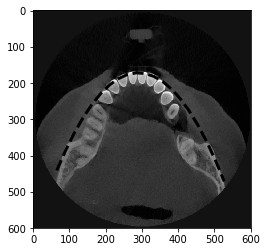

In [6]:
path_to_data = 'C:/Users/ekant/Desktop/'

name ='try.npz'


file = os.path.join(path_to_data, name)
file3d = np.load(file)
img3d = file3d['arr_0'];

height  = img3d.shape[2]


# for j in range(150,350):
#     show_img(img3d[:,:,j])
# #     print(selected_layers[j])
 
img3d= img3d[:,:,:]

model_version_sfx = 'v0'

cur_slice = img3d[:,:,250]
treshold_l = np.percentile(cur_slice, 75)
treshold_u = np.percentile(cur_slice, 95)
# In[] Fill panorama
parabola,a,b,c = fit_parabolic_spline(cur_slice, treshold_u)

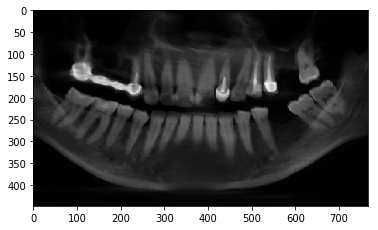

In [7]:
# sft=100

l1 = parabola[0,0].astype(int)
l2 = parabola[0,-1].astype(int)

x = np.linspace(l1,l2,l2-l1+1)
line =np.array([x, f(x,a,b,c)]).T
# line = line.astype(int)

L = int(parabola_length(l1,l2,a,b))
    
curve_params = (a,b,c)

# img = img3d[:,:,100]

# line  = np.mat(parabola).T

# In[] Build interpolation function
from scipy.interpolate import RegularGridInterpolator

img3d[img3d<treshold_l] = img3d[img3d<treshold_l]*0 # dont sum dark areas

volume = img3d
coords = tuple(map(lambda v: np.array(list(range(v))), volume.shape))
interpolating_fn = RegularGridInterpolator(coords, volume)

# In[] Fill panorama
width = int(parabola_length(l1,l2,a,b)) #l2-l1
   

long_line = line#Annotation.equalize_line(line, width, add_length=50)



def create_z(point):
    z = coords[2].reshape((coords[2].shape[0],1))    
    xy = np.tile(point, (len(z), 1))
    return np.hstack((xy, z))

# weigth along depth by summing several panoramax.
# each image should be generated from different parallel curve
canvases = []
for i in range(-10,70):
    canvas_curve = np.zeros((volume.shape[2], width))
    curve = get_parallel_curve(long_line, i)
    for j in range(width):
        x = int(findX(a,b,l1, j, L))-l1+1#j
#         print(x)
        pts = create_z(curve[x][::-1])
        canvas_curve[:,j] = interpolating_fn(pts)
    canvases.append(canvas_curve)
canvas = np.stack(canvases);
#    canvas -= canvas.min()
#    canvas += 1
canvas = np.mean(canvas, axis=0)
# canvas = sp.stats.gmean(canvas, axis=0)
# canvas = np.median(canvas, axis=0)

canvas_normalized = abs(canvas - canvas.min())#**(1)

# In[]

fig = plt.figure(2)

axes = fig.add_subplot(111, aspect='equal')

axes.imshow(canvas_normalized, cmap='Greys_r')
plt.show()

In [8]:
img3d.min()

-52

In [9]:
img3d[img3d<treshold_l] = img3d[img3d<treshold_l]*1.5

In [10]:
l2-l1

462

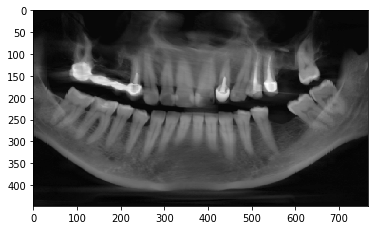

In [18]:
canvas_normalized = abs(canvas - canvas.min())**(2/3)

# In[]

fig = plt.figure(2)

axes = fig.add_subplot(111, aspect='equal')

axes.imshow(canvas_normalized, cmap='Greys_r')
plt.show()